## 17.3 リッジ回帰

### データを読み込む

In [4]:
import polars as pl

acs= pl.read_csv("../data/acs_ny.csv")
acs.head()

# 計画行列に変換する
from patsy import dmatrices
y, X = dmatrices(
    "FamilyIncome ~ NumBedrooms + NumChildren + NumPeople + "
    "NumRooms + NumUnits + NumVehicles + NumWorkers + OwnRent + "
    "YearBuilt + ElectricBill + FoodStamp + HeatingFuel + "
    "Insurance + Language",
    data = acs,
)

# 学習用と検証用に計画行列を分割する
from sklearn.model_selection import train_test_split
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, random_state = 0
)

### モデルのスコアを計算する

In [5]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# 学習器の初期化
model = make_pipeline(
    StandardScaler(with_mean = False),
    Ridge(random_state = 42),
)
display(model)

# 学習
model = model.fit(X_train, y_train)

model_coefs = pl.DataFrame({
    "variable": X.design_info.column_names,
    "coef_lr": model.named_steps["ridge"].coef_[0].round(4),
})
display(model_coefs)

# モデルのスコア
display(model.score(X_eval, y_eval).round(5))

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('ridge', Ridge(random_state=42))])

variable,coef_lr
str,f64
"""Intercept""",0.0
"""NumUnits[T.Sin…",9659.4135
"""NumUnits[T.Sin…",8342.2477
"""OwnRent[T.Outr…",2381.4296
"""OwnRent[T.Rent…",2259.5263
"""YearBuilt[T.19…",3075.6006
"""YearBuilt[T.19…",7229.9283
"""YearBuilt[T.19…",5280.8415
"""YearBuilt[T.19…",4920.6489


0.26979

### 残差のヒストグラム

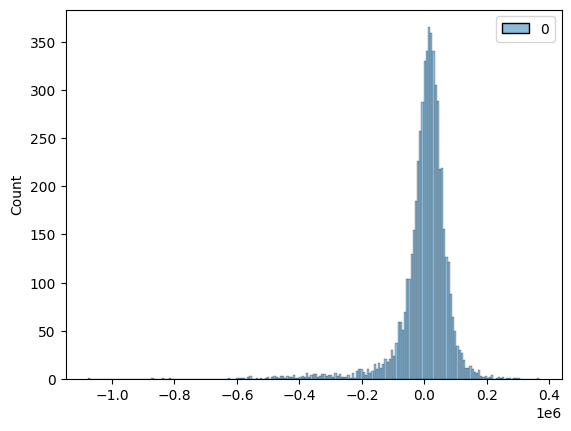

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 残差
residual = model.predict(X_eval) - y_eval

# ヒストグラム
fig, ax = plt.subplots()
sns.histplot(residual, ax = ax)
plt.show()